In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import logging
logging.basicConfig(level=logging.INFO)
np.random.seed(0)

In [3]:
from replay_identification.simulate import make_simulated_data

(is_replay, speed, position,
 power, spikes, time, multiunit) = make_simulated_data()

INFO:spectral_connectivity.transforms:Multitaper(sampling_frequency=1500, time_halfbandwidth_product=1,
           time_window_duration=0.02, time_window_step=0.0006666666666666666,
           detrend_type='constant', start_time=0, n_tapers=1)


In [105]:
from replay_identification.detectors import SortedSpikesDetector

detector = SortedSpikesDetector(discrete_state_transition_type='').fit(position, spikes)

INFO:replay_identification.detectors:Fitting discrete state transition...
INFO:replay_identification.detectors:Fitting continuous state transition...
INFO:replay_identification.detectors:Fitting place fields...


In [106]:
results = detector.predict(position, spikes, time=time)
results

INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...


<xarray.Dataset>
Dimensions:                (time: 97500, state: 2, position: 86)
Coordinates:
  * time                   (time) float64 0.0 0.0006667 0.001333 ... 65.0 65.0
  * position               (position) float64 0.9881 2.965 4.942 ... 167.0 169.0
  * state                  (state) <U9 'Local' 'Non-Local'
Data variables:
    causal_posterior       (time, state, position) float64 1.0 0.0 ... 2.437e-06
    likelihood             (time, state, position) float64 0.9946 ... 0.9935
    acausal_posterior      (time, state, position) float64 1.0 0.0 ... 2.437e-06
    non_local_probability  (time) float64 0.0 8.965e-05 ... 0.003309 0.003339
Attributes:
    data_log_likelihood:  -1261.4229072526787

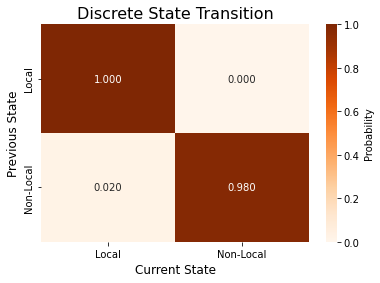

In [107]:
detector.plot_discrete_state_transition()

In [110]:
from scipy.special import logsumexp

EPS = 1e-32
try:
    causal_prob = np.log(
        results.causal_posterior.sum('position').values + EPS)
    acausal_prob = np.log(
        results.acausal_posterior.sum('position').values + EPS)
except ValueError:
    causal_prob = np.log(
        results.causal_posterior.sum(['x_position', 'y_position']).values +
        EPS)
    acausal_prob = np.log(
        results.acausal_posterior.sum(['x_position', 'y_position']).values
        + EPS)
    
old_discrete_state_transition = detector.discrete_state_transition_


n_states = old_discrete_state_transition.shape[0]

new_log_discrete_state_transition = np.empty((n_states, n_states))
for i in range(n_states):
    for j in range(n_states):
        new_log_discrete_state_transition[i, j] = logsumexp(
            old_discrete_state_transition[i, j] +
            causal_prob[:-1, i] +
            acausal_prob[1:, j] -
            causal_prob[1:, j])
        new_log_discrete_state_transition[i, j] -= logsumexp(
            acausal_prob[:-1, i])
new_log_discrete_state_transition -= logsumexp(
    new_log_discrete_state_transition, axis=-1, keepdims=True)
np.exp(new_log_discrete_state_transition)

array([[0.76004898, 0.23995102],
       [0.23991183, 0.76008817]])

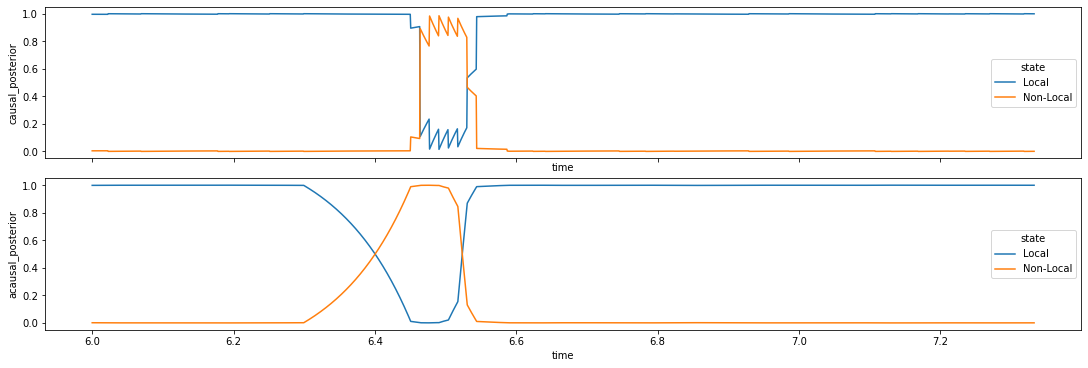

In [135]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, sharey=True, figsize=(15, 5))
results.isel(time=slice(9_000, 11_000)).causal_posterior.sum('position').plot(x='time', hue='state', ax=axes[0])
results.isel(time=slice(9_000, 11_000)).acausal_posterior.sum('position').plot(x='time', hue='state', ax=axes[1])

In [124]:
i = 0
j = 0

old_discrete_state_transition[i, j]

0.9999

In [82]:
import seaborn as sns

def plot_results(results, time, spikes, position):
    spike_ind, neuron_ind = np.nonzero(spikes)

    fig, axes = plt.subplots(4, 1, figsize=(18, 10), sharex=True, constrained_layout=True)
    axes[0].plot(time, position)
    axes[0].set_ylabel('Linear Distance')
    axes[0].set_title('Spikes')
    axes[1].scatter(time[spike_ind], neuron_ind + 1, color='black', s=2)
    axes[1].set_ylabel('Neuron Index')
    results.non_local_probability.plot(x='time', ax=axes[2], clip_on=False)
    axes[2].set_ylim((0, 1))
    axes[2].set_ylabel('Prob.')
    results.acausal_posterior.sum('state').plot(x='time', y='position', ax=axes[3], vmin=0.0, vmax=0.05)

    axes[-1].set_xlabel('Time');
    axes[-1].set_xlim((time[0], time[-1]))

    sns.despine()

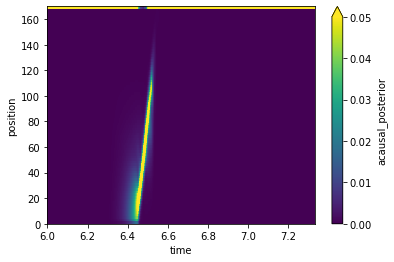

In [89]:
results.isel(time=slice(9_000, 11_000)).acausal_posterior.sum('state').plot(x='time', y='position', vmin=0.0, vmax=0.05)

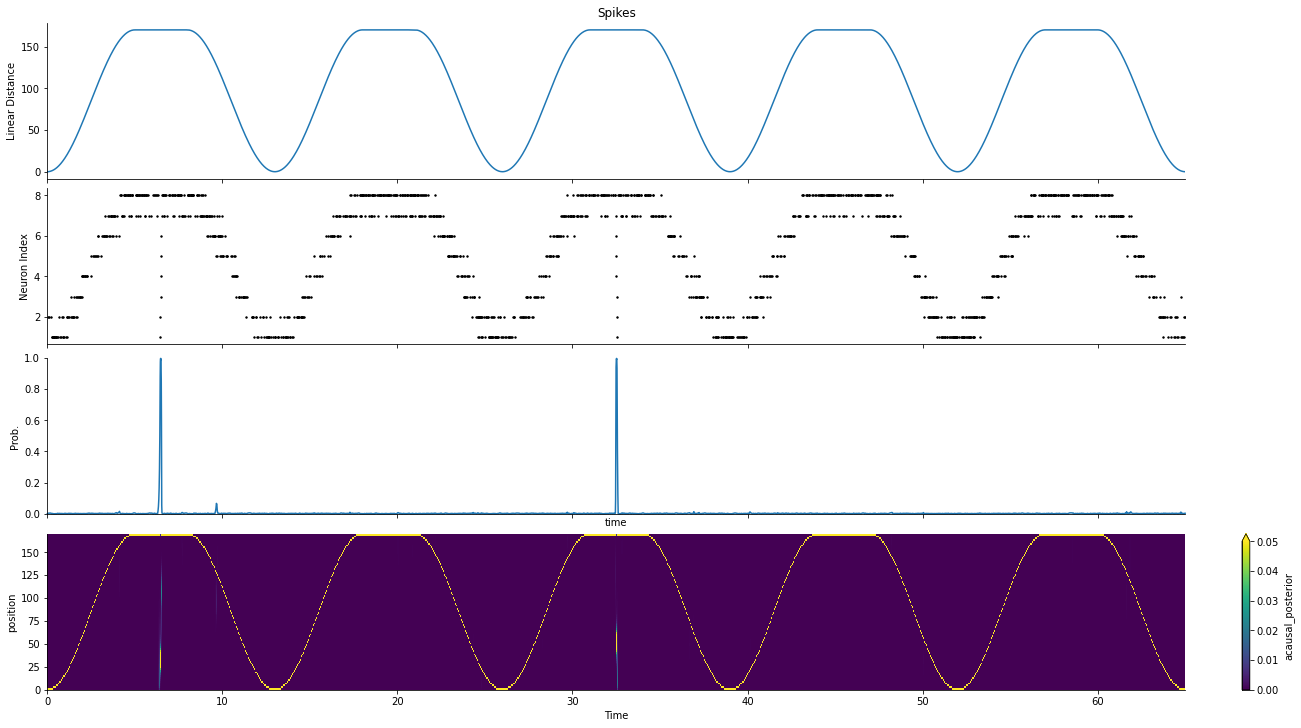

In [83]:
plot_results(results, time, spikes, position)

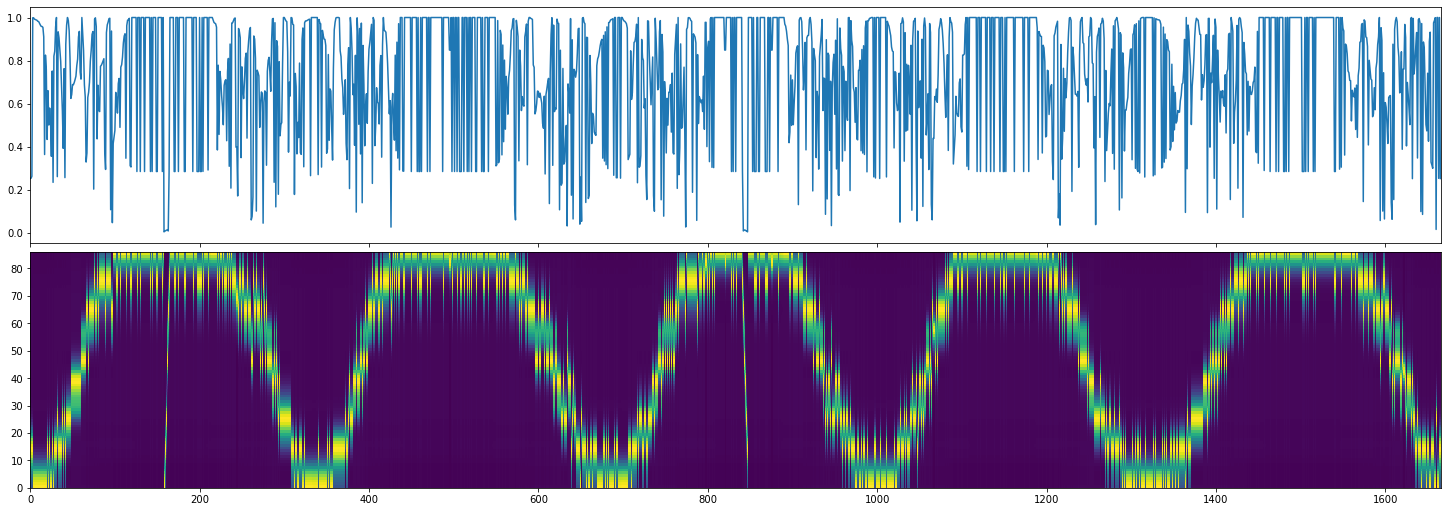

In [34]:
fig, axes = plt.subplots(2, 1, constrained_layout=True, sharex=True, figsize=(20, 7))
spike_ind, neuron_ind = np.nonzero(spikes)
axes[0].plot(likelihood[spike_ind, 0, 0])
axes[1].pcolormesh(likelihood[spike_ind, 1].T)

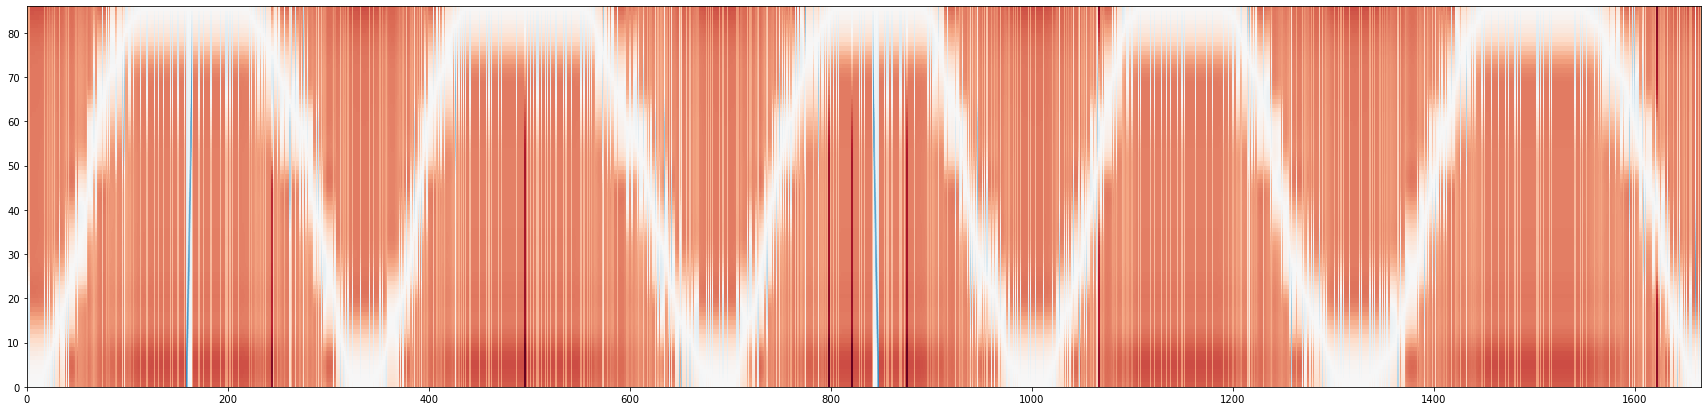

In [43]:
fig, ax = plt.subplots(1, 1, figsize=(30, 7))
likelihood_ratio = np.log(likelihood[spike_ind, 0]) - np.log(likelihood[spike_ind, 1])
g = ax.pcolormesh(likelihood_ratio.T, cmap='RdBu_r', vmin=-8, vmax=8)

INFO:replay_identification.detectors:Fitting discrete state transition...
INFO:replay_identification.detectors:Fitting continuous state transition...
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 0, likelihood: -1285.5739818385157
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 1, likelihood: -1274.9903799506408, change: 10.58360188787492
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 2, likelihood: -1270.3807187790603, change: 4.609661171580456
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 3, likelihood: -1268.0740522584547, change: 2.3066665206056314
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 4, likelihood: -1266.693150431892, change: 1.3809018265626491
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 5, likelihood: -1265.684636651982, change: 1.0085137799101176
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 6, likelihood: -1264.8267330403473, change: 0.8579036116345833
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 7, likelihood: -1264.0389110124572, change: 0.7878220278901154
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 8, likelihood: -1263.301019359497, change: 0.7378916529601156
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 9, likelihood: -1262.6173551283052, change: 0.6836642311918695
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 10, likelihood: -1262.0006402879576, change: 0.6167148403476403
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 11, likelihood: -1261.4647947842873, change: 0.5358455036703162
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 12, likelihood: -1261.0210949894026, change: 0.44369979488465106
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 13, likelihood: -1260.6753286287033, change: 0.34576636069937194
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 14, likelihood: -1260.4255899266934, change: 0.24973870200983583
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 15, likelihood: -1260.2615762882858, change: 0.16401363840759586
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 16, likelihood: -1260.166272773095, change: 0.09530351519083524


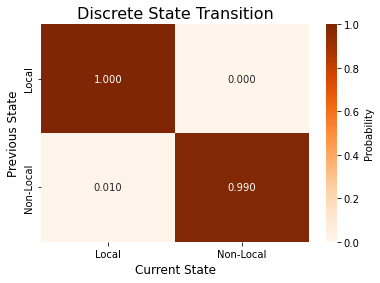

In [127]:
fit_args = dict(position=position, spikes=spikes)
predict_args = dict(position=position, spikes=spikes, time=time)
detector = SortedSpikesDetector(discrete_state_transition_type='')
results, data_log_likelihood = detector.estimate_parameters(
    fit_args,
    predict_args,
    tolerance=1E-4,
    max_iter=20,
    estimate_state_transition=True,
    estimate_likelihood=False)
detector.plot_discrete_state_transition()

INFO:replay_identification.detectors:Fitting discrete state transition...
INFO:replay_identification.detectors:Fitting continuous state transition...
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 0, likelihood: -1285.5739818385157
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 1, likelihood: -1305.2636620354394, change: -19.689680196923746
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 2, likelihood: -1290.9958836145445, change: 14.267778420894956
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 3, likelihood: -1282.341022903024, change: 8.654860711520541
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 4, likelihood: -1283.7373099970666, change: -1.396287094042691
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 5, likelihood: -1280.4446616383434, change: 3.292648358723227
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 6, likelihood: -1279.721395534406, change: 0.7232661039374761
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 7, likelihood: -1277.318948484986, change: 2.402447049419834
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 8, likelihood: -1276.235539106035, change: 1.0834093789510462
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 9, likelihood: -1275.6161095180155, change: 0.6194295880195568
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 10, likelihood: -1275.0779404373295, change: 0.5381690806859751
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 11, likelihood: -1272.9364527055384, change: 2.1414877317911305
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 12, likelihood: -1272.3304974340494, change: 0.6059552714889378
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 13, likelihood: -1273.424494905547, change: -1.0939974714974596
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 14, likelihood: -1272.8919481631367, change: 0.5325467424102044
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 15, likelihood: -1272.4440009429593, change: 0.4479472201774115
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 16, likelihood: -1272.1388414447727, change: 0.3051594981866401
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 17, likelihood: -1271.9145873064854, change: 0.2242541382872787
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 18, likelihood: -1271.7547517561966, change: 0.15983555028878982
INFO:replay_identification.detectors:Fitting place fields...
INFO:replay_identification.detectors:Estimating likelihood...


neurons:   0%|          | 0/8 [00:00<?, ?it/s]

neurons:   0%|          | 0/8 [00:00<?, ?it/s]

INFO:replay_identification.detectors:Finding causal non-local probability and position...
INFO:replay_identification.detectors:Finding acausal non-local probability and position...
INFO:replay_identification.detectors:iteration 19, likelihood: -1271.6429026709213, change: 0.11184908527525295


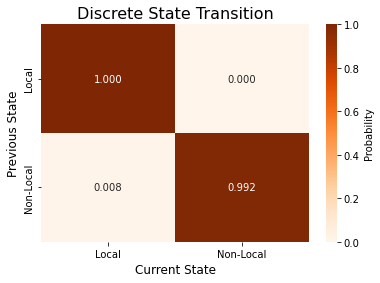

In [128]:
fit_args = dict(position=position, spikes=spikes)
predict_args = dict(position=position, spikes=spikes, time=time)
detector = SortedSpikesDetector(discrete_state_transition_type='')
results, data_log_likelihood = detector.estimate_parameters(
    fit_args,
    predict_args,
    tolerance=1E-4,
    max_iter=20,
    estimate_state_transition=True,
    estimate_likelihood=True)
detector.plot_discrete_state_transition()

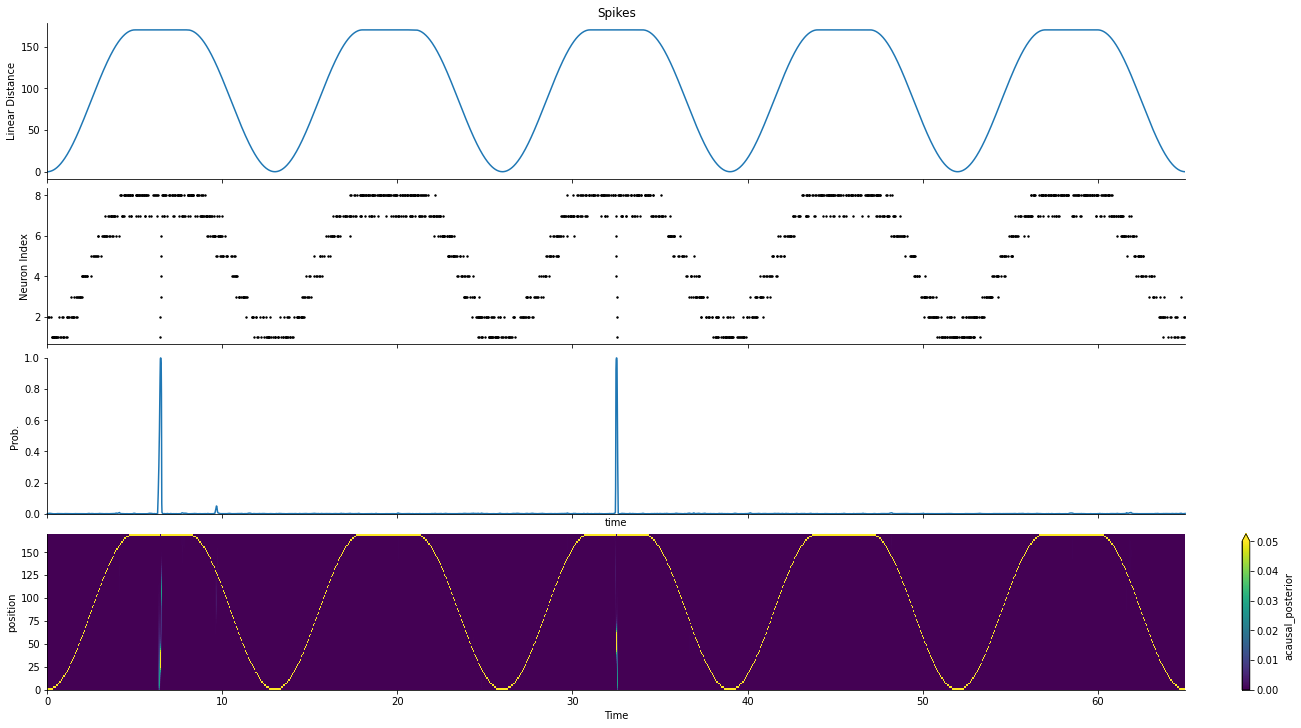

In [129]:
plot_results(results, time, spikes, position)